## Results using trajectories and callbacks

In [1]:
using DifferentialEquations
using Plots

In [10]:
0.85 * 1.2

1.02

In [2]:
f(x, p, t) = p .- x # the system ("unit first-order lag")
ctrl_f(e, x) = 0.85(e + 1.2x) # the controller (proportional-integral)
ctrl_x = [0.0] # array to record (discrete) state of controller

function ctrl_cb(int) # the callback function
    e = 1 - int.u[1]               # control error
    push!(ctrl_x, ctrl_x[end] + e) # integrate the control error
    int.p = ctrl_f(e, ctrl_x[end]) # update controller output
end

ctrl_cb (generic function with 1 method)

In [3]:
for _ in 1:4
    @time begin
        f(x, p, t) = p .- x # the system ("unit first-order lag")
        pcb  = PeriodicCallback(ctrl_cb, 1.0)
        prob = ODEProblem(f, [0.0], (0.0, 5.0), 0.0, callback=pcb)
        sol  = DifferentialEquations.solve(prob)
    end
end

 11.201559 seconds (24.14 M allocations: 1.230 GiB, 10.02% gc time)
  0.000355 seconds (2.04 k allocations: 188.281 KiB)
  0.000266 seconds (2.04 k allocations: 188.141 KiB)
  0.000232 seconds (2.04 k allocations: 188.406 KiB)


In [6]:
pcb  = PeriodicCallback(ctrl_cb, 1.0)
prob = ODEProblem(f, [0.0], (0.0, 5.0), 0.0, callback=pcb)
@time begin sol = DifferentialEquations.solve(prob) end;

  0.000337 seconds (1.76 k allocations: 166.906 KiB)


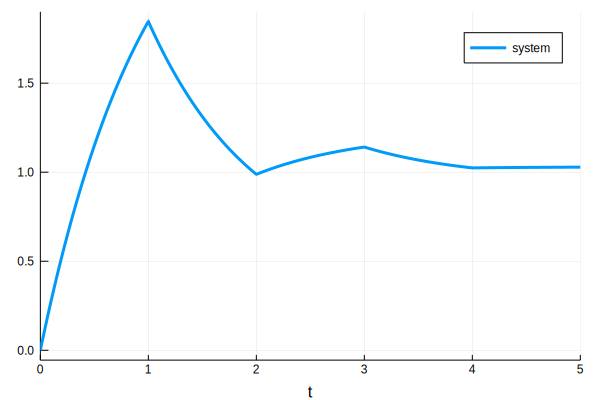

In [7]:
fig = plot(sol, label="system")

#=
ctrl_t = 0:(length(ctrl_x)-2)
plot!(fig, 0:(length(ctrl_x)-2), ctrl_f.(1 .- sol(ctrl_t, idxs=1).u, ctrl_x[2:end]),
      color=:black, linetype=:steppost, label="controller")
=#

## Results using reachability computations (I) initial point

The set-based simulation is 5x faster than the single trajectory.

One can also simulate a "robust" trajectory, i.e. in dense time = the real solution is included in the flowpipe by taking a `Singleton([0.0])` as initial condition, or just `Interval(0.0, 0.0)`.

In [8]:
# =======================
# Dependencies
# =======================

using Reachability, LazySets.Approximations, MathematicalSystems, Plots
const CLCCS = ConstrainedLinearControlContinuousSystem
const IVP = InitialValueProblem

┌ Warning: 
│ 
│     # Breaking changes
│ 
│     `TaylorIntegration.jl` follows now (≥ v0.5.0) the convention
│     of `DifferentialEquations.jl` for the function containing
│     the differential equation to be integrated. The function
│     must have the form `f(x, p, t)` for one dependent variable,
│     or `f!(dx, x, p, t)` for several dependent variables, where
│     `dx` is mutated.
│ 
└ @ TaylorIntegration /Users/forets/.julia/dev/TaylorIntegration/src/TaylorIntegration.jl:21


InitialValueProblem

In [9]:
# =======================
# Initialization
# =======================

ctrl_f(e, x) = 0.85(e + 1.2x) # the controller (proportional-integral)

# side note: this function can be made more efficient by writing the concrete operations at once,
# but let's keep things lazy so it can be compared line by line to the original model that uses floats
function ctrl_cb(int) # the callback function
    e = (hcat([-1.0]) * int) ⊕ [1.0]                  # control error
    push!(ctrl_x, ctrl_x[end] ⊕ e |> overapproximate) # integrate the control error
    p = ctrl_f(e, ctrl_x[end]) |> overapproximate     # update controller output
end

X0 = Singleton([0.0])
A, B, X = hcat(-1.0), I(1), Universe(1)

ctrl_x = Vector{Hyperrectangle{Float64}}()            # array to record (discrete) state of controller
push!(ctrl_x, Hyperrectangle(low=[0.0], high=[0.0]));

T = 5                 # discrete time horizon
δ = [fill(1e-3, T-2); fill(1e-3, 2)]     # step size for each chunk
Nind = Int.(1.0 ./ δ) # number of indices in each chunk

opts = Options(:T=>1.0, :project_reachset=>false)   # generic options
solver_opts(k) = Options(:δ=>δ[k])                  # algorithm-specific options

sol = Vector{ReachSolution{CartesianProductArray{Float64,LazySet{Float64}}}}(); # preallocate flowpipe

In [10]:
# =======================
# Solution
# =======================

for k in 1:T
    U = ctrl_cb(X0)            # update controller state
    system = CLCCS(A, B, X, U) # instantiate the system ("unit first-order lag")
    problem = IVP(system, X0)
    @time sol_ti = Reachability.solve(problem, opts, op=BFFPSV18(solver_opts(k)))
    push!(sol, sol_ti)         # store
    X0 = sol_ti.Xk[end].X      # update initial condition for the next iteration
end

  0.035535 seconds (60.12 k allocations: 3.595 MiB)
  0.021631 seconds (59.58 k allocations: 3.565 MiB)
  0.067044 seconds (59.43 k allocations: 3.556 MiB, 64.72% gc time)
  0.028501 seconds (59.58 k allocations: 3.565 MiB)
  0.019707 seconds (59.43 k allocations: 3.556 MiB)


In [11]:
1.11 / (0.033 + 0.024 + 0.061 + 0.034 + 0.027)

6.201117318435755

In [12]:
# =======================
# Projection and plotting
# =======================

# auxiliary function to shift a flowpipe by a given time lapse
function shift_flowpipe(sol, c)
    sol_shifted_Xk = Vector{ReachSet{CartesianProductArray{Float64,LazySet{Float64}}}}()
    
    for Rset in sol.Xk
        Rset_shifted = ReachSet(Rset.X, Rset.t_start + c, Rset.t_end + c)
        push!(sol_shifted_Xk, Rset_shifted)
    end
    return ReachSolution(sol_shifted_Xk, sol.options)
end

# auxiliary function to project the flowpipe
project_flowpipe(fp) = [πsol.X for πsol in Reachability.project(fp)] # 2D sets (t, x)

project_flowpipe (generic function with 1 method)

In [13]:
sol_projected = Vector{Vector{Hyperrectangle{Float64}}}()
push!(sol_projected, project_flowpipe(sol[1]));
c = 1.0 # clock
for k in 2:T
    push!(sol_projected, shift_flowpipe(sol[k], c) |> project_flowpipe)
    c += 1.0
end;

Let's plot the first two solutions:

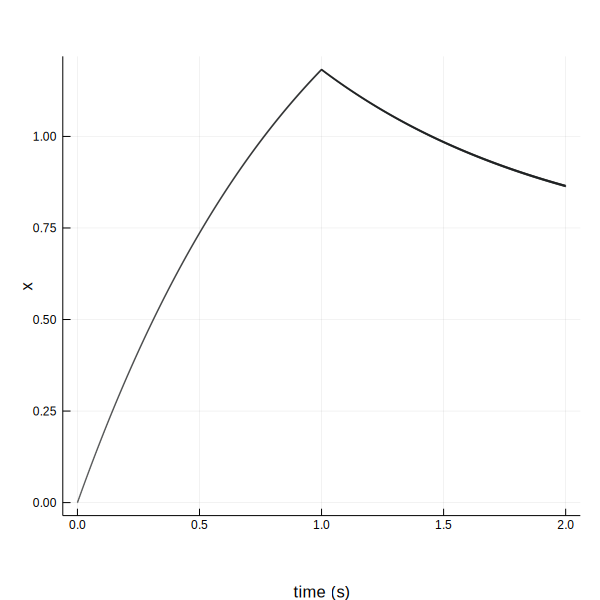

In [14]:
plot(sol_projected[1][1:1:Nind[1]], xlab="time (s)", ylab="x", alpha=.4, color=:lightblue, aspectratio=1.5)
plot!(sol_projected[2][1:1:Nind[2]], alpha=.4, color=:lightblue, aspectratio=1.5, size=(600, 600))

Next we superpose the plot obtained with a trajectory and that with reachability:

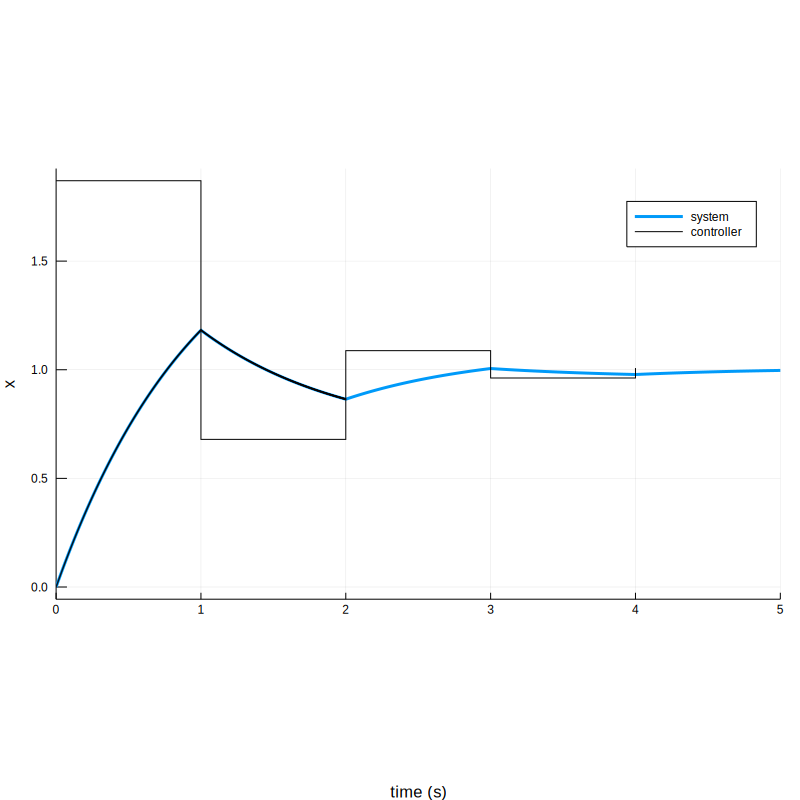

In [15]:
plot!(fig, sol_projected[1][1:1:Nind[1]], alpha=.5, color=:red, aspectratio=1.5,  size=(800, 800))
plot!(fig, sol_projected[2][1:1:Nind[2]], xlab="time (s)", ylab="x", alpha=.5, color=:red, aspectratio=1.5, size=(800, 800))

We see that it matches the trajectory in blue, tightly.

With the following function we plot all the chunks:

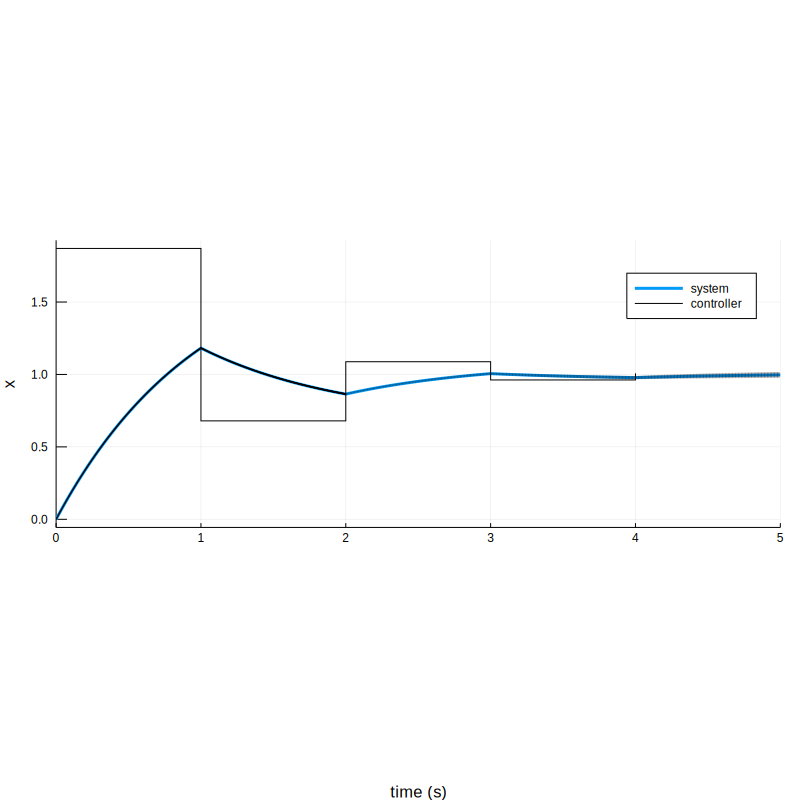

In [16]:
# plot!(fig, sol_projected[1][1:10:Nind[1]], xlab="time (s)", ylab="x", alpha=.5, color=:red, aspectratio=1.5)
c = 1.0 # clock
for k in 2:T
    plot!(fig, sol_projected[k][1:10:Nind[k]], alpha=.4, color=:red, size=(800, 800))
    c += 1.0
end
fig

## Results using reachability computations (II) initial set

Now we repeat the calculation but instead of using a point as the initial condition, we use a *set*. Since the system is one-dimensional, we can use an interval.

In [39]:
# =======================
# Initialization
# =======================

ctrl_f(e, x) = 0.85(e + 1.2x) # the controller (proportional-integral)

# side note: this function can be made more efficient by writing the concrete operations at once,
# but let's keep things lazy so it can be compared line by line to the original model that uses floats
function ctrl_cb(int) # the callback function
    e = (hcat([-1.0]) * int) ⊕ [1.0]                  # control error
    push!(ctrl_x, ctrl_x[end] ⊕ e |> overapproximate) # integrate the control error
    p = ctrl_f(e, ctrl_x[end]) |> overapproximate     # update controller output
end

X0 = Interval([0.0, 0.02])
A, B, X = hcat(-1.0), I(1), Universe(1)

ctrl_x = Vector{Hyperrectangle{Float64}}()            # array to record (discrete) state of controller
push!(ctrl_x, Hyperrectangle(low=[0.0], high=[0.0]));

T = 5                 # discrete time horizon
δ = fill(1e-5, T)     # step size for each chunk
Nind = round.(Int, 1.0 ./ δ) # number of indices in each chunk

opts = Options(:T=>1.0, :project_reachset=>false)   # generic options
solver_opts(k) = Options(:δ=>δ[k])                  # algorithm-specific options

sol = Vector{ReachSolution{CartesianProductArray{Float64,LazySet{Float64}}}}(); # preallocate flowpipe

# =======================
# Solution
# =======================

for k in 1:T
    U = ctrl_cb(X0)            # update controller state
    system = CLCCS(A, B, X, U) # instantiate the system ("unit first-order lag")
    problem = IVP(system, X0)
    @time sol_ti = Reachability.solve(problem, opts, op=BFFPSV18(solver_opts(k)))
    push!(sol, sol_ti)         # store
    X0 = sol_ti.Xk[end].X      # update initial condition for the next iteration
end

Computing successors  86%|█████████████████████████▊    |  ETA: 0:00:00

  1.457882 seconds (5.90 M allocations: 332.173 MiB, 64.45% gc time)


Computing successors 100%|██████████████████████████████| Time: 0:00:01


  0.866200 seconds (5.90 M allocations: 332.116 MiB, 40.82% gc time)
  0.974595 seconds (5.90 M allocations: 332.116 MiB, 40.60% gc time)


Computing successors  41%|████████████▍                 |  ETA: 0:00:02

  1.598515 seconds (5.90 M allocations: 332.141 MiB, 64.68% gc time)


Computing successors 100%|██████████████████████████████| Time: 0:00:02
Computing successors  86%|█████████████████████████▉    |  ETA: 0:00:00

  1.190494 seconds (5.90 M allocations: 332.151 MiB, 48.84% gc time)


Computing successors 100%|██████████████████████████████| Time: 0:00:01


In [40]:
# =======================
# Projection and plotting
# =======================

sol_projected = Vector{Vector{Hyperrectangle{Float64}}}()
push!(sol_projected, project_flowpipe(sol[1]));
c = 1.0 # clock
for k in 2:T
    push!(sol_projected, shift_flowpipe(sol[k], c) |> project_flowpipe)
    c += 1.0
end;

fig = plot(sol_projected[1][1:100:Nind[1]], xlab="time (s)", ylab="x", alpha=.5, color=:red, aspectratio=1.5)
c = 1.0 # clock
for k in 2:T
    plot!(fig, sol_projected[k][1:100:Nind[k]], alpha=.4, color=:red, size=(800, 800))
    c += 1.0
end
fig